Link to the original data and challenge

https://physionet.org/content/challenge-2017/1.0.0/

# I. Environment setup

NumPy, Pandas → Data handling

Matplotlib, Seaborn → Visualization

SciPy → Signal processing

Scikit-learn → Machine learning

TensorFlow, PyTorch → Deep learning

WFDB → Handling PhysioNet data

h5py → Loading .mat files

Neurokit2 → ECG preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import scipy.io
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm

# II. Data Exploration

### 1. Exploration of the sample A00001

In [ ]:
# load the sample A00001

hea_file = '/content/drive/My Drive/Healthcare (AI in)/AI in Healthcare/Project/Data/training2017/A00001.hea'
mat_file = '/content/drive/My Drive/Healthcare (AI in)/AI in Healthcare/Project/Data/training2017/A00001.mat'


In [ ]:
#read the sample .mat
mat_data = scipy.io.loadmat(mat_file)

print("Keys in the file .mat :", mat_data.keys())

for key in mat_data:
    if not key.startswith("__"):  # Avoid internal metadata
        print(f"\nClé : {key}")
        print(mat_data[key])

Keys in the file .mat : dict_keys(['val'])

Clé : val
[[-127 -162 -197 ...  -18  -22  -21]]


In [ ]:
#read the sample .mat
data = scipy.io.loadmat(mat_file)
ecg_signal = data['val'][0]  # Extract ECG waveform
print(f"ECG data : {ecg_signal[:10]} ...")

ECG data : [-127 -162 -197 -229 -245 -254 -261 -265 -268 -268] ...


In [ ]:
#read the sample .hea
with open(hea_file, "r") as f:
    metadata = f.readlines()
print(metadata)

['A00001 1 300 9000 05:05:15 1/05/2000 \n', 'A00001.mat 16+24 1000/mV 16 0 -127 0 0 ECG \n']


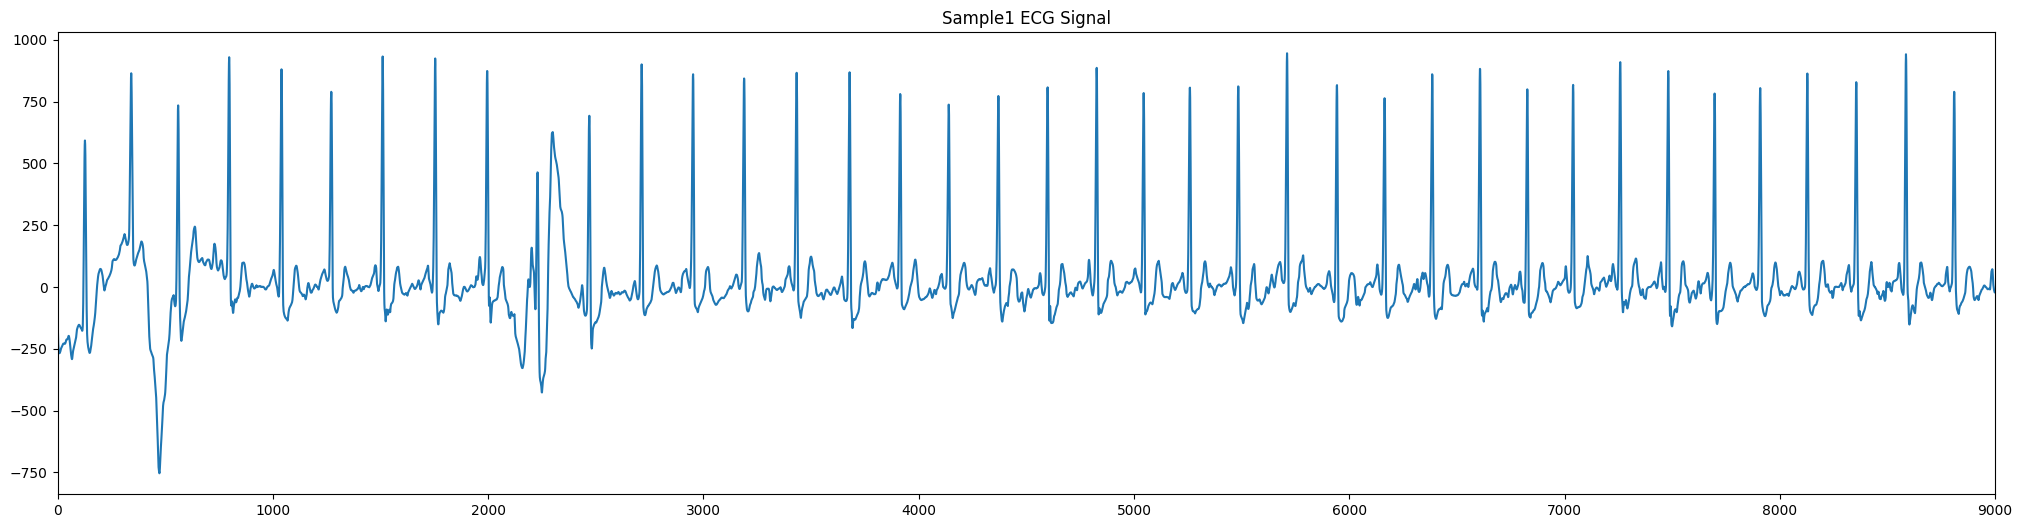

In [ ]:
#visualize ECG signal
plt.figure(figsize=(25, 6))
plt.plot(ecg_signal[:9000])  # Plot first few seconds
plt.title("Sample1 ECG Signal")
plt.xlim(0, 9000)
plt.show()

So, here we can see that the file .hea is a file with the metadata, and the file.mat is a file with the ECG data.



### 2. Exploration of all the samples

So, now the idea for exploration is to create a dataframe to gather the metadata of all the samples to see if it's uniform or not, and what should we do in the pre processing part.

In [ ]:
data_path = '/content/drive/My Drive/Healthcare (AI in)/AI in Healthcare/Project/Data/training2017/'

#### a) Transformation into CSV files and merging

In [ ]:
# Path to all the .hea files
hea_folder = data_path

# List to stock data of .hea files
hea_data = []

for filename in tqdm(os.listdir(hea_folder)):
    if filename.endswith(".hea"):
        filepath = os.path.join(hea_folder, filename)

        with open(filepath, "r") as f:
            lines = f.readlines()

            # Line 1 : General information
            first_line = lines[0].strip().split()
            file_id = first_line[0]  # Name of the file (ex: A00001)
            num_leads = int(first_line[1])  # Number of leads (ex: 1)
            sampling_rate = int(first_line[2])  # Frequency (ex: 300 Hz)
            num_samples = int(first_line[3])  # Number of samples (ex: 9000)

            # Ligne 2 : ECG signal information
            second_line = lines[1].strip().split()
            gain = float(second_line[2].split('/')[0])  # Signal gain (ex: 1000/mV → 1000)
            offset = int(second_line[5])  # Offset DC (ex: -127)
            signal_type = second_line[-1]  # Signal type (ex: ECG)

            # Add to the DataFrame
            hea_data.append([file_id, num_leads, sampling_rate, num_samples, gain, offset, signal_type])

# DataFrame creation
hea_df = pd.DataFrame(hea_data, columns=["File_ID", "Num_Leads", "Sampling_Rate", "Num_Samples", "Gain", "Offset", "Signal_Type"])

print(hea_df.head())

# Record the df
hea_df.to_csv("hea_metadata.csv", index=False)


100%|██████████| 17056/17056 [1:44:50<00:00,  2.71it/s]

  File_ID  Num_Leads  Sampling_Rate  Num_Samples    Gain  Offset Signal_Type
0  A08031          1            300        18000  1000.0     254         ECG
1  A08033          1            300         9000  1000.0     216         ECG
2  A08035          1            300         9000  1000.0    -403         ECG
3  A08032          1            300         9000  1000.0    -230         ECG
4  A08029          1            300         9000  1000.0     908         ECG


In [ ]:
mat_folder = data_path

mat_data = []

for filename in tqdm(os.listdir(mat_folder)):
    if filename.endswith(".mat"):
        file_id = filename.split(".")[0]  # Extract name of the file (ex: A00001)
        file_path = os.path.join(mat_folder, filename)

        try:
            data = scipy.io.loadmat(file_path)
            ecg_signal = data['val'][0]  # Extract the ECG signal

            mat_data.append([file_id, ecg_signal.tolist()])

        except Exception as e:
            print(f"Error with {filename} : {e}")

# Create a df
mat_df = pd.DataFrame(mat_data, columns=["File_ID", "ECG_Signal"])

# Save into CSV
mat_df.to_csv("ecg_signals.csv", index=False)

print("File saved : ecg_signals.csv")
print(mat_df.head())

 58%|█████▊    | 9841/17056 [1:01:23<55:17,  2.17it/s]

In [ ]:

hea_df = pd.read_csv("hea_metadata.csv")
ecg_df = pd.read_csv("ecg_signals.csv")

# Merge on File_ID
full_df = pd.merge(hea_df, ecg_df, on="File_ID")

full_df.to_csv("full_ecg_metadata.csv", index=False)
print("File saved : full_ecg_metadata.csv")


#### b) Exploration

In [ ]:
# check if there is different frequency
print(hea_df["Sampling_Rate"].value_counts())

Sampling_Rate
300    8528
Name: count, dtype: int64


In [ ]:
# check gain
print(hea_df["Gain"].describe())

count    8528.0
mean     1000.0
std         0.0
min      1000.0
25%      1000.0
50%      1000.0
75%      1000.0
max      1000.0
Name: Gain, dtype: float64


In [ ]:
# check if different offsets
print(hea_df["Offset"].value_counts())

Offset
 21      47
-19      46
-23      46
 0       44
 17      43
         ..
 617      1
-1328     1
-1931     1
 654      1
-961      1
Name: count, Length: 1781, dtype: int64
